<a href="https://colab.research.google.com/github/jmin07/Next-Frame-Prediction-Using-Beta-VAE/blob/main/video_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 실험 데이터

In [ ]:
from google.colab import drive

# Mount your Google Drive
drive.mount('/content/drive')

In [ ]:
import cv2
import numpy as np

# 원하는 FPS 설정
target_fps = 35

frame_size = (128, 128)

# 프레임을 그룹화하여 데이터 구성
X = []  # 입력 데이터
y = []  # 레이블(예측할 다음 프레임)

for num in range(1, 4):
    # 각 비디오 파일에 대해 반복
    frames = []  # 여러 비디오에서 추출한 프레임을 저장할 리스트

    video_path = '/content/drive/MyDrive/05.학교/2024/실험/01. DataSet/driving/video' + str(num) + '.mp4'
    # 비디오 캡처 객체 생성
    cap = cv2.VideoCapture(video_path)

    # 원래 비디오의 FPS 확인
    original_fps = cap.get(cv2.CAP_PROP_FPS)

    # 프레임 스킵 비율 계산 (원래 FPS가 타겟 FPS보다 높을 경우에만 적용)
    skip_rate = max(1, round(original_fps / target_fps))  # skip_rate가 최소 1이 되도록 설정

    frame_count = 0  # 읽은 프레임 수

    # 비디오에서 프레임 읽기
    while True:
        ret, frame = cap.read()
        if not ret:
            break  # 비디오 끝에 도달하면 반복문 종료

        # 원하는 FPS에 맞게 프레임 스킵
        if frame_count % skip_rate == 0:
            resized_frame = cv2.resize(frame, frame_size, interpolation=cv2.INTER_AREA)
            frames.append(resized_frame)

        frame_count += 1

    # 비디오 캡처 객체 해제
    cap.release()

    for i in range(len(frames) - 5):
        X.append(frames[i:i+5])  # 연속적인 5개의 프레임을 입력 데이터로 추가
        y.append(frames[i+5])    # 그 다음 프레임을 예측할 레이블로 추가


# 입력 데이터와 레이블을 numpy 배열로 변환
X = np.array(X)
y = np.array(y)

print(X.shape)
print(y.shape)

(6619, 5, 128, 128, 3)
(6619, 128, 128, 3)


In [ ]:
from sklearn.model_selection import train_test_split

# 데이터 분할 비율 설정 (예: 80% 훈련, 20% 테스트)
train_size = 0.9

# 훈련 데이터와 검증 데이터로 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, random_state=42)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (5957, 5, 128, 128, 3)
y_train shape: (5957, 128, 128, 3)
X_test shape: (662, 5, 128, 128, 3)
y_test shape: (662, 128, 128, 3)


In [ ]:
# X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.
# y_train = y_train.astype('float32') / 255.
y_test = y_test.astype('float32') / 255.

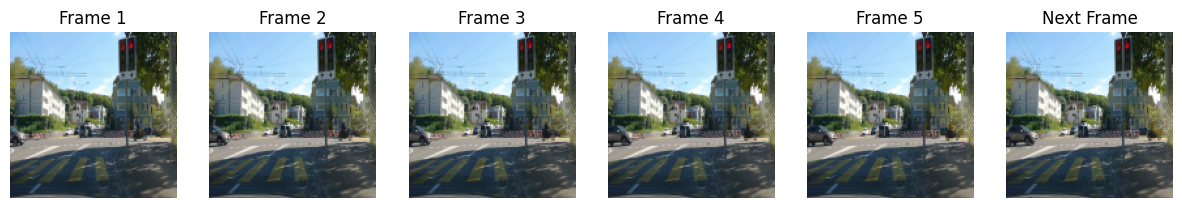

In [ ]:
import matplotlib.pyplot as plt

index = 50

# 첫 번째 그룹의 프레임 시각화 (입력 데이터 X 중 첫 번째)
fig, axs = plt.subplots(1, 6, figsize=(15, 10))  # 5개의 연속 프레임과 1개의 예측 프레임을 위한 subplot 준비

for i, ax in enumerate(axs.flat[:5]):
    ax.imshow(cv2.cvtColor(X_train[index][i], cv2.COLOR_BGR2RGB))  # OpenCV는 BGR 형식을 사용하므로, RGB로 변환
    ax.set_title(f'Frame {i+1}')
    ax.axis('off')  # 축 제거

# 예측해야 할 다음 프레임(y 중 첫 번째) 시각화
axs.flat[5].imshow(cv2.cvtColor(y_train[index], cv2.COLOR_BGR2RGB))
axs.flat[5].set_title('Next Frame')
axs.flat[5].axis('off')

plt.show()

# 제안하는 모델

In [ ]:
!pip install tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 9.3 MB/s eta 0:00:00


In [ ]:
from tensorflow.keras import layers, models, Input
import tensorflow as tf
import tensorflow_addons as tfa

def build_vgg_encoder(input_shape, latent_dim):
    inputs = Input(shape=input_shape)  # 예: (5, 64, 64, 1)

    # 첫 번째 Conv2D 레이어 적용
    x = layers.TimeDistributed(layers.Conv2D(filters=latent_dim, kernel_size=(3, 3), strides=(2, 2), padding='same'))(inputs)
    x = layers.TimeDistributed(layers.LeakyReLU())(x)
    x = layers.TimeDistributed(layers.AveragePooling2D((2, 2), strides=(1, 1), padding='same'))(x)
    x = tfa.layers.GroupNormalization(groups=1)(x)
    x_128 = tf.keras.layers.Lambda(lambda x: x[:, 4])(x)
    # print(x_128.shape)

    # 두 번째 Conv2D 레이어 적용
    x = layers.TimeDistributed(layers.Conv2D(filters=latent_dim / 2, kernel_size=(3, 3), strides=(2, 2), padding='same'))(x)
    x = layers.TimeDistributed(layers.LeakyReLU())(x)
    x = layers.TimeDistributed(layers.AveragePooling2D((2, 2), strides=(1, 1), padding='same'))(x)
    x = tfa.layers.GroupNormalization(groups=8)(x)
    x_64 = tf.keras.layers.Lambda(lambda x: x[:, 3])(x)
    # print(x_64.shape)

    # 세 번째 Conv2D 레이어 적용
    x = layers.TimeDistributed(layers.Conv2D(filters=latent_dim / 4, kernel_size=(3, 3), strides=(2, 2), padding='same'))(x)
    x = layers.TimeDistributed(layers.LeakyReLU())(x)
    x = layers.TimeDistributed(layers.AveragePooling2D((2, 2), strides=(1, 1), padding='same'))(x)
    x = tfa.layers.GroupNormalization(groups=8)(x)

    x = layers.ConvLSTM2D(filters=latent_dim, kernel_size=(3, 3), strides=(1, 1), padding='same', return_sequences=False)(x)

    # 잠재 공간 정의
    z_mean = layers.Conv2D(latent_dim, (1, 1), name='z_mean')(x)
    z_log_var = layers.Conv2D(latent_dim, (1, 1), name='z_log_var')(x)

    # Lambda 레이어를 통한 샘플링
    z = layers.Lambda(lambda t: t[0] + tf.random.normal(tf.shape(t[0])) * tf.exp(t[1] / 2), name='z')([z_mean, z_log_var])

    # 모델 인스턴스화
    model = models.Model(inputs, [z_mean, z_log_var, z, x_128, x_64], name='vgg_encoder')
    return model


In [ ]:
from tensorflow.keras import layers, models

def inception_module(inputs, filters):
    # 1x1 convolution
    conv1 = layers.Conv2D(filters=filters[0], kernel_size=(1, 1), padding='same')(inputs)

    # 3x3 convolution
    conv3 = layers.Conv2D(filters=filters[1], kernel_size=(3, 3), padding='same')(inputs)

    # 5x5 convolution
    conv5 = layers.Conv2D(filters=filters[2], kernel_size=(5, 5), padding='same')(inputs)

    # Concatenate all the convolutions
    x = layers.concatenate([conv1, conv3, conv5], axis=-1)

    return x

def build_translator(input_shape, latent_dim):
    inputs = layers.Input(shape=input_shape)

    # inception_module 함수 호출 수정
    x = inception_module(inputs, filters=latent_dim)
    x = inception_module(x, filters=latent_dim)
    x = inception_module(x, filters=latent_dim)
    x = inception_module(x, filters=latent_dim)

    x_translator = layers.Conv2D(filters=64, kernel_size=(1, 1), padding='same')(x)

    model = models.Model(inputs=inputs, outputs=x_translator, name='translator')

    return model


In [ ]:
def channel_attention(input_feature, ratio=8):
    channel_axis = -1
    channel = input_feature.shape[channel_axis]

    shared_layer_one = layers.Dense(channel//ratio,
                                    activation='relu',
                                    kernel_initializer='he_normal',
                                    use_bias=True,
                                    bias_initializer='zeros')
    shared_layer_two = layers.Dense(channel,
                                    kernel_initializer='he_normal',
                                    use_bias=True,
                                    bias_initializer='zeros')

    avg_pool = layers.GlobalAveragePooling2D()(input_feature)
    avg_pool = layers.Reshape((1, 1, channel))(avg_pool)
    avg_pool = shared_layer_one(avg_pool)
    avg_pool = shared_layer_two(avg_pool)

    max_pool = layers.GlobalMaxPooling2D()(input_feature)
    max_pool = layers.Reshape((1, 1, channel))(max_pool)
    max_pool = shared_layer_one(max_pool)
    max_pool = shared_layer_two(max_pool)

    cbam_feature = layers.Add()([avg_pool, max_pool])
    cbam_feature = layers.Activation('sigmoid')(cbam_feature)

    return layers.multiply([input_feature, cbam_feature])

def spatial_attention(input_feature):
    kernel_size = 7

    avg_pool = layers.Lambda(lambda x: tf.reduce_mean(x, axis=-1, keepdims=True))(input_feature)
    max_pool = layers.Lambda(lambda x: tf.reduce_max(x, axis=-1, keepdims=True))(input_feature)
    concat = layers.Concatenate(axis=-1)([avg_pool, max_pool])
    cbam_feature = layers.Conv2D(filters=1,
                                 kernel_size=kernel_size,
                                 strides=1,
                                 padding='same',
                                 activation='sigmoid',
                                 kernel_initializer='he_normal',
                                 use_bias=False)(concat)

    return layers.multiply([input_feature, cbam_feature])

def cbam_block(cbam_feature, ratio=8):
    cbam_feature = channel_attention(cbam_feature, ratio)
    cbam_feature = spatial_attention(cbam_feature)
    return cbam_feature


In [ ]:
from tensorflow.keras import layers, models, Input
import tensorflow as tf

def identity_block(input_tensor, kernel_size, filters,group):
    """
    ResNet의 Identity Block을 정의하는 함수입니다.
    """
    filters1, filters2, filters3 = filters
    x = layers.Conv2D(filters1, (1, 1), padding='same')(input_tensor)
    x = layers.LeakyReLU()(x)
    x = tfa.layers.GroupNormalization(groups=group)(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters2, kernel_size, padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = tfa.layers.GroupNormalization(groups=group)(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters3, (1, 1), padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = tfa.layers.GroupNormalization(groups=group)(x)

    x = layers.add([x, input_tensor])
    x = layers.Activation('relu')(x)
    return x

def build_deep_resnet_vgg_decoder(latent_dim, input_shapes, dropout_rate=0.5):
    x_input_last = layers.Input(shape=input_shapes['x_input_last'], name='x_input_last')
    x_128 = layers.Input(shape=input_shapes['x_128'], name='x_128')
    x_64 = layers.Input(shape=input_shapes['x_64'], name='x_64')
    x_translator = layers.Input(shape=input_shapes['x_translator'], name='x_translator')  # 잠재 벡터

    # 첫 번째 Conv2DTranspose와 Conv2D의 조합
    x = layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', name='Conv2DTranspose_1')(x_translator)
    x = layers.LeakyReLU()(x)
    x = tfa.layers.GroupNormalization(groups=8)(x)
    x = layers.Concatenate(axis=-1)([x, x_64])
    x = identity_block(x, 3, [128, 128, 128], 8)
    x = cbam_block(x, ratio=8)

    # 두 번째 Conv2DTranspose와 Conv2D 조합
    x = layers.Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', name='Conv2DTranspose_2')(x)
    x = layers.LeakyReLU()(x)
    x = tfa.layers.GroupNormalization(groups=8)(x)
    x = layers.Concatenate(axis=-1)([x, x_128])
    x = identity_block(x, 3, [160, 160, 160], 8)
    x = cbam_block(x, ratio=8)

    # 세 번째 Conv2DTranspose와 추가적인 Identity Block
    x = layers.Conv2DTranspose(16, (3, 3), strides=(2, 2), padding='same', name='Conv2DTranspose_3')(x)
    x = layers.LeakyReLU()(x)
    x = layers.Conv2DTranspose(8, (1, 1), strides=(1, 1), padding='same', name='Conv2DTranspose_4')(x)
    x = layers.LeakyReLU()(x)
    x = tfa.layers.GroupNormalization(groups=8)(x)

    x = layers.Conv2DTranspose(3, (1, 1), strides=(1, 1), padding='same', name='Conv2DTranspose_5')(x)
    x = layers.Concatenate(axis=-1)([x, x_input_last])
    x = layers.LeakyReLU()(x)
    x = layers.Conv2DTranspose(3, (1, 1), strides=(1, 1), padding='same', name='Conv2DTranspose_6')(x)
    x = layers.LeakyReLU()(x)
    x = layers.Conv2DTranspose(3, (1, 1), strides=(1, 1), padding='same', name='Conv2DTranspose_7')(x)
    x = layers.LeakyReLU()(x)
    x = identity_block(x, 3, [3, 3, 3], 3)
    x = cbam_block(x, ratio=8)

    # print(x.shape)

    # # 최종 Conv2D로 출력 형상을 (64, 64, 1)로 조정
    # x = layers.Conv2D(64, (3, 3), strides=(2, 2), activation='relu', padding='same', name='Conv2D_3')(x)
    # print(x.shape)
    # x = layers.Conv2D(3, (3, 3), strides=(1, 1), activation='relu', padding='same', name='Conv2D_4')(x)
    # x = layers.Dropout(dropout_rate, name='Dropout_4')(x)
    # x = layers.Conv2D(3, (3, 3), strides=(1, 1), activation='relu', padding='same', name='Conv2D_5')(x)
    # x = layers.Conv2D(3, (3, 3), strides=(1, 1), activation='relu', padding='same', name='Conv2D_6')(x)

    outputs = x  # 최종 출력 형상을 (64, 64, 1)에 맞춤

    decoder = models.Model(inputs=[x_128, x_64, x_input_last, x_translator], outputs=outputs, name='deep_resnet_vgg_decoder')
    return decoder

# decoder = build_deep_resnet_vgg_decoder(latent_dim, input_shapes)
# decoder.summary()

In [ ]:
class VAE(tf.keras.Model):
    def __init__(self, encoder, translator, decoder, beta=1.0, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.beta = beta
        self.encoder = encoder
        self.decoder = decoder
        self.translator = translator
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    @tf.function
    def train_step(self, data):
        x, y = data
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z, x_128, x_64 = self.encoder(x)
            x_last = tf.keras.layers.Lambda(lambda x: x[:, 4])(x)
            output_translator = self.translator(z)
            reconstruction = self.decoder([x_128, x_64, x_last, output_translator])
            # binary_crossentropy를 mse로 수정
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    tf.keras.losses.mean_squared_error(y, reconstruction)
                )
            )

            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + self.beta * kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


    @tf.function
    def test_step(self, data):
        x, y = data
        z_mean, z_log_var, z, x_128, x_64 = self.encoder(x)
        x_last = tf.keras.layers.Lambda(lambda x: x[:, 4])(x)
        output_translator = self.translator(z)
        reconstruction = self.decoder([x_128, x_64, x_last, output_translator])
        reconstruction_loss = tf.reduce_mean(
            tf.reduce_sum(
                tf.keras.losses.mean_squared_error(y, reconstruction)
            )
        )
        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
        total_loss = reconstruction_loss + self.beta * kl_loss

        return {"val_loss": total_loss, "val_reconstruction_loss": reconstruction_loss, "val_kl_loss": kl_loss}




In [ ]:
# 필요한 라이브러리 불러오기
import tensorflow as tf

# VAE 모델 인스턴스 생성
encoder = build_vgg_encoder(input_shape=(5, 128, 128, 3), latent_dim=128)
input_shapes = {
    'x_128': (64, 64, 128),
    'x_64': (32, 32, 64),
    'x_input_last' : (128, 128, 3),
    'x_translator': (16, 16, 64)
}
translator = build_translator(input_shape=(16, 16, 128), latent_dim=[64, 64, 64])
decoder = build_deep_resnet_vgg_decoder(latent_dim=64, input_shapes=input_shapes)
vae_model = VAE(encoder, translator, decoder, beta=0.8)

# 모델 학습
for epoch in [100]:
    vae_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0015), metrics=['loss', 'reconstruction_loss', 'kl_loss'])
    vae_model.fit(X_train, y_train, epochs=epoch, validation_split=0.2, batch_size=32)

    # 에포크마다 모델 저장 (.h5 포맷)
    vae_model.encoder.save('/content/drive/MyDrive/05.학교/2024/실험/02.model_result/h5/encoder_video_' + str(epoch) + '.h5')
    vae_model.translator.save('/content/drive/MyDrive/05.학교/2024/실험/02.model_result/h5/translator_video_' + str(epoch) + '.h5')
    vae_model.decoder.save('/content/drive/MyDrive/05.학교/2024/실험/02.model_result/h5/decoder_video_' + str(epoch) + '.h5')


# 학습 결과 확인

In [ ]:
!pip install tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 6.8 MB/s eta 0:00:00


In [ ]:
from keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
from google.colab import drive

# Mount your Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def plot_sequence_with_target(X, y, index=0):
    """
    특정 인덱스의 이미지 시퀀스와 타겟 이미지를 시각화합니다.

    Parameters:
    - X: 이미지 시퀀스 데이터 (샘플 수, 시퀀스 길이, 높이, 너비)
    - y: 타겟 이미지 데이터 (샘플 수, 높이, 너비)
    - index: 시각화할 샘플의 인덱스
    """
    sequence_length = X.shape[1]

    fig, axes = plt.subplots(1, sequence_length + 1, figsize=(sequence_length * 2 + 2, 2))

    # 시퀀스의 이미지들을 표시
    for i, img in enumerate(X[index]):
        axes[i].imshow(cv2.cvtColor(img.squeeze(), cv2.COLOR_BGR2RGB))  # squeeze()는 채널 차원이 1인 경우 제거
        axes[i].axis('off')
        axes[i].set_title(f'Step {i+1}')

    # 타겟 이미지 표시
    axes[-1].imshow(cv2.cvtColor(y[index].squeeze(), cv2.COLOR_BGR2RGB))
    axes[-1].axis('off')
    axes[-1].set_title('Target')

    plt.tight_layout()
    plt.show()

In [ ]:
index = 15

In [ ]:
with tf.keras.utils.custom_object_scope({'GroupNormalization': tfa.layers.GroupNormalization}):

    # 모델 로드
    encoder_model = load_model('/content/drive/MyDrive/05.학교/2024/실험/02.model_result/h5/encoder_video_100.h5')
    translator_model = load_model('/content/drive/MyDrive/05.학교/2024/실험/02.model_result/h5/translator_video_100.h5')
    decoder_model = load_model('/content/drive/MyDrive/05.학교/2024/실험/02.model_result/h5/decoder_video_100.h5')

# 입력 데이터 예시 (임의의 데이터로 가정)
# (1, 5, 64, 64, 1) 형태의 입력 데이터

# 모델 예측
new_arr = X_test[index][np.newaxis, ...]
z_mean, z_log_var, z, x_128, x_64 = encoder_model.predict(new_arr)
x_output = translator_model(z)
x_last = tf.keras.layers.Lambda(lambda new_arr: new_arr[:, 4])(new_arr)
predicted_image = decoder_model.predict([x_128, x_64, x_last, x_output])

# 이미지를 0에서 255 사이의 값으로 되돌리는 함수
def rescale_image(image):
    image *= 255.0  # 0-1 범위를 0-255 범위로 스케일링
    return image.astype('uint8')  # 데이터 타입을 uint8로 변경하여 정수화

rescaled_predicted_image = rescale_image(predicted_image)


# 예측 결과 시각화
# 첫 번째 이미지의 예측 결과 시각화 (출력 데이터는 (64, 64, 1) 형태)
plt.imshow(cv2.cvtColor(rescaled_predicted_image[0, :, :, :], cv2.COLOR_BGR2RGB))
plt.title('Predicted Image')
plt.axis('off') # 축 표시 안 함
plt.show()


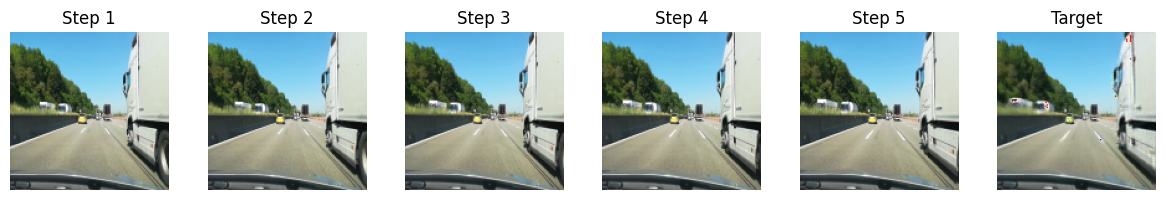

In [ ]:
plot_sequence_with_target(new_arr, rescaled_predicted_image, 0)

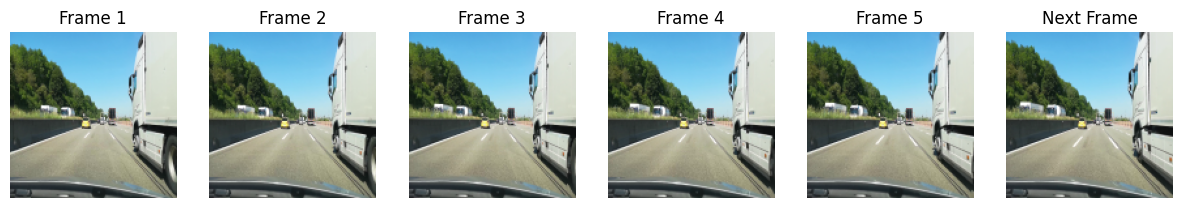

In [ ]:
import matplotlib.pyplot as plt

# 첫 번째 그룹의 프레임 시각화 (입력 데이터 X 중 첫 번째)
fig, axs = plt.subplots(1, 6, figsize=(15, 10))  # 5개의 연속 프레임과 1개의 예측 프레임을 위한 subplot 준비

for i, ax in enumerate(axs.flat[:5]):
    ax.imshow(cv2.cvtColor(X_test[index][i], cv2.COLOR_BGR2RGB))  # OpenCV는 BGR 형식을 사용하므로, RGB로 변환
    ax.set_title(f'Frame {i+1}')
    ax.axis('off')  # 축 제거

# 예측해야 할 다음 프레임(y 중 첫 번째) 시각화
axs.flat[5].imshow(cv2.cvtColor(y_test[index], cv2.COLOR_BGR2RGB))
axs.flat[5].set_title('Next Frame')
axs.flat[5].axis('off')

plt.show()